In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# For the purpose of recreatability, we will set a random seed:
seed = 2000

# Reading in & Splitting the Data

Note that we only have a dataset of 200 entries. In the context of this problem, in order to evaluate the performance of each model, we will opt to split the dataset into a training dataset (100 rows) & testing dataset (100 rows).

We will opt to build the required models on the training dataset and the indication of the model's performance will be through the testing dataset.

Note that based on the nature of the dataset, this will be a classification problem

In [3]:
# Load Data
icu_data = pd.read_csv('ICU.csv')

# Dropping unnecessary columns (The Indexing and ID doesn't appear to be as useful)
icu_data = icu_data.drop(columns = ['Unnamed: 0', 'ID'])

icu_data

,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
0,0,87,3,1,1,80,96,1
1,1,27,1,1,1,142,88,1
2,1,59,2,0,0,112,80,1
3,1,77,3,0,0,100,70,0
4,0,76,3,1,1,128,90,1
...,...,...,...,...,...,...,...,...
195,0,50,2,1,0,256,64,1
196,1,20,1,0,0,104,83,1
197,1,73,3,1,0,162,100,1
198,1,59,2,0,0,100,88,1


In [4]:
# Splitting the Data
train_icu, test_icu = train_test_split(icu_data, test_size = 100, train_size = 100, random_state = seed)

# Display the DataFrames
display(train_icu)
display(test_icu)

,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
118,0,71,3,1,0,70,112,1
23,1,72,3,0,0,120,80,0
10,1,35,1,0,0,108,60,1
186,1,69,2,0,0,169,73,1
162,0,69,2,0,0,80,81,1
...,...,...,...,...,...,...,...,...
28,1,61,2,0,1,110,120,1
123,1,77,3,1,0,212,87,0
54,1,66,2,0,1,150,120,0
72,1,69,2,0,0,170,100,0


,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
47,0,91,3,0,1,64,125,1
140,1,46,1,0,0,110,128,0
139,1,60,2,0,1,124,135,1
25,1,78,3,0,0,180,75,0
113,1,72,3,0,0,126,88,0
...,...,...,...,...,...,...,...,...
198,1,59,2,0,0,100,88,1
133,1,24,1,1,0,140,86,1
76,1,77,3,0,1,158,107,0
42,1,73,3,1,0,134,60,0


# EDA on the Training DataSet

From what we observe, we establish a few facts before proceding:

1. There is no missing data from observing the dataset
2. Survive is the truth column for our case
3. Numeric Columns are Age, SysBP, Pulse; Categorical Columns are AgeGroup, Sex, Infection, Emergency
4. Age & Age Group are correlated

In [5]:
# Describing Dataset
train_icu.describe()

,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.830000,55.330000,1.920000,0.390000,0.420000,132.690000,99.290000,0.710000
std,0.377525,20.732084,0.774336,0.490207,0.496045,35.539335,26.636837,0.456048
min,0.000000,16.000000,1.000000,0.000000,0.000000,36.000000,39.000000,0.000000
25%,1.000000,40.000000,1.000000,0.000000,0.000000,110.000000,80.000000,0.000000
50%,1.000000,63.000000,2.000000,0.000000,0.000000,134.000000,97.000000,1.000000
75%,1.000000,70.000000,3.000000,1.000000,1.000000,150.000000,120.000000,1.000000
max,1.000000,92.000000,3.000000,1.000000,1.000000,256.000000,170.000000,1.000000


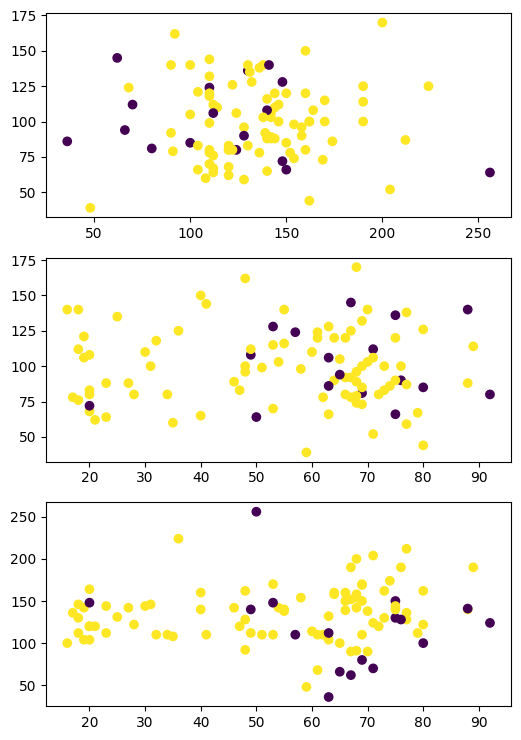

In [6]:
truth = 'Survive'

fig, ax = plt.subplots(3, figsize = (6, 9))

# Generating Some Plots
ax[0].scatter(train_icu['SysBP'], train_icu['Pulse'], c = train_icu[truth])
ax[1].scatter(train_icu['Age'], train_icu['Pulse'], c = train_icu[truth])
ax[2].scatter(train_icu['Age'], train_icu['SysBP'], c = train_icu[truth])

In [7]:
# Obseriving Imbalance on Train Data:
survive_count = sum(train_icu[truth])
survive_count

83

A Few things we will do before proceding:
1. We observe that this dataset appears to be imbalanced based on the survival count, so we will opt to balance by introducing SMOTE when performing cross validation
2. We will use One-Hot Encoding on AgeGroup as the categories appear to be 1, 2, 3
3. We will convert all categorical columns to factors

Note: That AgeGroups 1: < 50, 2: 50 <= x <= 69, 3: >= 70
We will remove the AgeGroup Column and put it back after the Resampling; Note this must be done to prevent cases where the Age & AgeGroup do not match up.

# Utility Function

Unfortunately, due to there being an imbalance in the distribution of the truth data, we will opt at using a custom cross-validation function based on GridSearchCV, to properly use SMOTE in cross-validation.

In [8]:
# Reinserting the AgeGroup
def age_group_sep(x):
    assert x >= 0, 'Age cannot be smaller than 0'
    if x < 50:
        return 1
    elif x < 70:
        return 2
    else:
        return 3

# Enumerating list of Parameters based on Param Grid
def param_grid_enumerating(param_grid):
    
    param_list = []

    if type(param_grid) == dict:
        to_enum = [param_grid]
    else:
        to_enum = param_grid

    # Creating the Multiple Params for Grid Search
    for sets in to_enum:
        to_extend = [dict()]
        keys = list(sets.keys())
        for key in keys:
            to_pop = to_extend.copy()
            to_extend.clear()
            param_ls = sets[key]
            while to_pop:
                cur_dict = to_pop.pop()
                for item in param_ls:
                    dict_copy = cur_dict.copy()
                    dict_copy[key] = item
                    to_extend.append(dict_copy)
        param_list.extend(to_extend)
    
    return param_list
    
# Making Predictions
def model_predict(test_data, test_cols, truth_col, estimator):
    results = estimator.predict(test_data[test_cols])
    results = pd.DataFrame(results, columns = ['prediction'])
    return pd.concat([results, test_data[truth]], axis = 1)

# Function to return the confusion matrix and other useful metrics
def eval_metric(results):
    y_pred, y_test = results['prediction'], results['Survive']
    
    # Obtaining Confusion matrix
    cfn_mat = confusion_matrix(y_pred = y_pred, y_true = y_test, labels = [0, 1])

    # Individuals:
    tn, fp, fn, tp = cfn_mat[0][0], cfn_mat[0][1], cfn_mat[1][0], cfn_mat[1][1]

    # Sensitivity, Specificity, Accuracy, Precision, f1
    sensitivity, specificity, accuracy, precision = tp/(tp + fn), tn/(tn + fp), (tp + tn)/(tp + tn + fp + fn), tp/(tp + fp)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    balanced_accuracy = (sensitivity + specificity) / 2

    # Output Dictionary of Metrics
    metric_dict = {'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Accuracy': accuracy,
            'Precision': precision,
            'F1': f1,
            'Balanced Accuracy': balanced_accuracy}
    return cfn_mat, metric_dict
    
# Fits and Returns a best_params & Score
def cross_validation(dataset, estimator, param_grid, resample_columns, truth_col, numeric_cols, categorical_cols, scoring = 'Balanced Accuracy', folds = 5, seed = seed):  

    # Check if estimator is either LogisticRegression, Decision Tree, RandomForest
    assert estimator in ['log', 'd_tree', 'r_for'], "Estimator Choice Not in Scope!"
    
    ########################
    # Generating the folds #
    ########################

    train_sample_length = len(dataset)
    if train_sample_length % folds == 0:
        number_of_repeats = train_sample_length // folds
    else:
        number_of_repeats = train_sample_length // folds + 1
    
    # Setting Seed & Generating the permutation
    np.random.seed(seed)
    permutation = np.random.permutation(np.repeat(np.asarray([i for i in range(1, folds + 1)]), number_of_repeats))[:train_sample_length]

    # Enumerating the param grid
    param_list = param_grid_enumerating(param_grid)

    #################
    # Performing CV #
    #################

    result_list = []

    # For each param, we run 
    for param_set in param_list:
        score = 0
        for i in range(1, 6):

            # Splitting the Dataset
            dataset_train, dataset_val = dataset[permutation != i].copy(), dataset[permutation == i].copy()

            ############################# 
            # Train Dataset Preparation #
            #############################

            # Performing SMOTE on Train
            sm = SMOTE(random_state = seed)
            X_train_over, y_train_over = sm.fit_resample(dataset_train[resample_columns], dataset_train[truth_col])

            # One Hot Encoding AgeGroup
            X_train_over['AgeGroup'] = X_train_over['Age'].apply(lambda x: age_group_sep(x))
            age_groups = pd.get_dummies(X_train_over['AgeGroup']).drop(columns = [1]).rename(columns = {2: 'AgeGroup_2', 3: 'AgeGroup_3'})
            train_icu_over = pd.concat([X_train_over, age_groups, y_train_over], axis = 1) # We keep the AgeGroup column just in case we want to use it moving

            # Converting Categorical to Factors 
            for col in categorical_cols:
                train_icu_over[col] = train_icu_over[col].astype('category')

            # Converting Output & Age Group to Factors
            train_icu_over['AgeGroup'] = train_icu_over['AgeGroup'].astype('category')
            train_icu_over[truth_col] = train_icu_over[truth_col].astype('category')
            
            ################################## 
            # Validation Dataset Preparation #
            ##################################

            dataset_val['AgeGroup'] = dataset_val['Age'].apply(lambda x: age_group_sep(x))
            X_test, y_test = dataset_val[resample_columns + ['AgeGroup']], dataset_val[truth_col]
            age_group_test = pd.get_dummies(X_test['AgeGroup']).drop(columns = [1]).rename(columns = {2: 'AgeGroup_2', 3: 'AgeGroup_3'})

            # Reconstructing the Test Dataset
            test_icu_processed = pd.concat([X_test, age_group_test, y_test], axis = 1).reset_index(drop = True)

            # Processing the Columns into categories:
            for col in categorical_cols:
                test_icu_processed[col] = test_icu_processed[col].astype('category')

            # AgeGroup & Output
            test_icu_processed['AgeGroup'] = test_icu_processed['AgeGroup'].astype('category')
            test_icu_processed[truth_col] = test_icu_processed[truth_col].astype('category')
            
            #####################
            # Scoring the Model #
            #####################

            # Defining Model
            if estimator == 'log':
                model = LogisticRegression(random_state = seed,
                                           max_iter = 10000,
                                           **param_set)
            elif estimator == 'd_tree':
                model = DecisionTreeClassifier(random_state = seed,
                                               **param_set)
            else:
                model = RandomForestClassifier(n_estimators = 100,
                                               random_state = seed,
                                               **param_set)
            
            # Training Model
            X, y = train_icu_over[numeric_cols + categorical_cols], train_icu_over[truth_col]
            model.fit(X, y)
            results = model_predict(test_icu_processed, test_cols = numeric_cols + categorical_cols, truth_col = truth_col, estimator = model)
            reg_metrics = eval_metric(results)
            score += reg_metrics[1][scoring]
        
        # Append Results
        score = score/folds
        result_list.append((score, param_set))
    best_output = max(result_list, key = lambda x: x[0])
    return best_output

# Training Data Preprocessing for Full Testing

Since the Age & AgeGroup columns are heavily linked, we will opt to use only the one-hot encoded Categorical AgeGroup columns in this study.

In [9]:
resample_columns = ['Age', 'SysBP', 'Pulse', 'Sex', 'Infection', 'Emergency']
numeric_cols = ['SysBP', 'Pulse']
categorical_cols = ['Sex', 'Infection', 'Emergency', 'AgeGroup_2', 'AgeGroup_3']
#categorical_cols = ['Sex', 'Infection', 'Emergency', 'AgeGroup']
#categorical_cols = ['Sex', 'Infection', 'Emergency']

Note that the Oversampling of the entire training dataset is meant for fitting the final model after Cross Validation.

We perform it now for simplicity of using it again later.

In [10]:
# Resample Preparation
X_train = train_icu[resample_columns]
y_train = train_icu[[truth]]

# CV Preparation (This is the Dataset used for Cross Validation)
cv_train_dataset = pd.concat([X_train, y_train], axis = 1)

In [11]:
# Over Sample
sm = SMOTE(random_state = seed)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

# Reinserting the AgeGroup
X_train_over['AgeGroup'] = X_train_over['Age'].apply(lambda x: age_group_sep(x))

# One Hot Encoding AgeGroup
age_groups = pd.get_dummies(X_train_over['AgeGroup']).drop(columns = [1]).rename(columns = {2: 'AgeGroup_2', 3: 'AgeGroup_3'})

# Modifying the Dataset
train_icu_over = pd.concat([X_train_over, age_groups, y_train_over], axis = 1) # We keep the AgeGroup column just in case we want to use it moving

# Converting Categorical to Factors
for col in categorical_cols:
    train_icu_over[col] = train_icu_over[col].astype('category')

# Converting Output & Age Group to Factors
train_icu_over['AgeGroup'] = train_icu_over['AgeGroup'].astype('category')
train_icu_over[truth] = train_icu_over[truth].astype('category')

train_icu_over


,Age,SysBP,Pulse,Sex,Infection,Emergency,AgeGroup,AgeGroup_2,AgeGroup_3,Survive
0,71,70,112,1,0,1,3,0,1,0
1,72,120,80,0,0,0,3,0,1,1
2,35,108,60,0,0,1,1,0,0,1
3,69,169,73,0,0,1,2,1,0,1
4,69,80,81,0,0,1,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...
161,68,149,66,0,0,1,2,1,0,0
162,79,97,85,0,0,1,3,0,1,0
163,55,136,103,0,1,1,2,1,0,0
164,52,128,114,0,1,1,2,1,0,0


In [12]:
# For fitting the final models
X, y = train_icu_over[numeric_cols + categorical_cols], train_icu_over[truth]

# Test Data Preprocessing

In [13]:
X_test, y_test = test_icu[resample_columns + ['AgeGroup']], test_icu[truth]
age_group_test = pd.get_dummies(X_test['AgeGroup']).drop(columns = [1]).rename(columns = {2: 'AgeGroup_2', 3: 'AgeGroup_3'})

# Reconstructing the Test Dataset
test_icu_processed = pd.concat([X_test, age_group_test, y_test], axis = 1).reset_index(drop = True)

# Processing the Columns into categories:
for col in categorical_cols:
    test_icu_processed[col] = test_icu_processed[col].astype('category')

# AgeGroup & Output
test_icu_processed['AgeGroup'] = test_icu_processed['AgeGroup'].astype('category')
test_icu_processed[truth] = test_icu_processed[truth].astype('category')

test_icu_processed

,Age,SysBP,Pulse,Sex,Infection,Emergency,AgeGroup,AgeGroup_2,AgeGroup_3,Survive
0,91,64,125,0,1,1,3,0,1,0
1,46,110,128,0,0,0,1,0,0,1
2,60,124,135,0,1,1,2,1,0,1
3,78,180,75,0,0,0,3,0,1,1
4,72,126,88,0,0,0,3,0,1,1
...,...,...,...,...,...,...,...,...,...,...
95,59,100,88,0,0,1,2,1,0,1
96,24,140,86,1,0,1,1,0,0,1
97,77,158,107,0,1,0,3,0,1,1
98,73,134,60,1,0,0,3,0,1,1


# Modelling

# Logistic Regression

In [14]:
# Defining LogReg object
log_reg_estimator = LogisticRegression(random_state = seed, max_iter = 10000)

# Param Grid
log_param_grid = [{'penalty': [None],
                   'solver': ['lbfgs']},
                  {'penalty': ['elasticnet'],
                   'l1_ratio': [0, 0.1, 0.3, 0.5, 1.0],
                   'C': [0.1, 0.3, 0.5, 1.0],
                   'solver': ['saga']}]

log_reg_best_score, log_reg_best_param = cross_validation(dataset = cv_train_dataset,
                                                          estimator = 'log',
                                                          param_grid = log_param_grid,
                                                          resample_columns = resample_columns,
                                                          truth_col = truth,
                                                          numeric_cols = numeric_cols,
                                                          categorical_cols = categorical_cols)

print('CV Best Params:', log_reg_best_param)
print('CV Best Scores:', log_reg_best_score)

CV Best Params: {'penalty': 'elasticnet', 'l1_ratio': 0, 'C': 1.0, 'solver': 'saga'}
CV Best Scores: 0.6709150326797386


In [15]:
# Fitting the Data
log_reg_best = LogisticRegression(random_state = seed, max_iter = 10000, **log_reg_best_param)
log_reg_best.fit(X, y)

# making predictions
log_reg_results = model_predict(test_icu_processed, test_cols = numeric_cols + categorical_cols, truth_col = truth, estimator = log_reg_best)

# Obtain the Metrics
log_reg_cfn_mat, log_reg_metrics = eval_metric(log_reg_results)

print("Confusion Matrix: \n", log_reg_cfn_mat)
print("Logistic Regression Metrics:", log_reg_metrics)

Confusion Matrix: 
 [[16  7]
 [28 49]]
Logistic Regression Metrics: {'Sensitivity': 0.6363636363636364, 'Specificity': 0.6956521739130435, 'Accuracy': 0.65, 'Precision': 0.875, 'F1': 0.7368421052631579, 'Balanced Accuracy': 0.6660079051383399}


# Decision Tree

In [16]:
# Defining Decision Tree Object
d_tree_estimator = DecisionTreeClassifier(random_state = seed)

# Param Grid (Pruning)
d_tree_param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
                     'max_depth': [5, 10, 20, None],
                     'min_samples_split': [2, 5],
                     'min_samples_leaf': [1, 3, 5]}

d_tree_best_score, d_tree_best_param = cross_validation(dataset = cv_train_dataset,
                                                          estimator = 'd_tree',
                                                          param_grid = d_tree_param_grid,
                                                          resample_columns = resample_columns,
                                                          truth_col = truth,
                                                          numeric_cols = numeric_cols,
                                                          categorical_cols = categorical_cols)


print('CV Best Params:', d_tree_best_param)
print('CV Best Scores:', d_tree_best_score)

CV Best Params: {'criterion': 'log_loss', 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1}
CV Best Scores: 0.5371556956115779


In [17]:
# Fitting the Data
d_tree_best = DecisionTreeClassifier(random_state = seed, **d_tree_best_param)
d_tree_best.fit(X, y)

# making predictions
d_tree_results = model_predict(test_icu_processed, test_cols = numeric_cols + categorical_cols, truth_col = truth, estimator = d_tree_best)

# Obtain the Metrics
d_tree_cfn_mat, d_tree_metrics = eval_metric(d_tree_results)

print("Confusion Matrix: \n", d_tree_cfn_mat)
print("Decision Tree Metrics:", d_tree_metrics)

Confusion Matrix: 
 [[ 9 14]
 [20 57]]
Decision Tree Metrics: {'Sensitivity': 0.7402597402597403, 'Specificity': 0.391304347826087, 'Accuracy': 0.66, 'Precision': 0.8028169014084507, 'F1': 0.7702702702702703, 'Balanced Accuracy': 0.5657820440429137}


# Random Forest

In [18]:
# Defining Decision Tree Object
r_forest_estimator = RandomForestClassifier(n_estimators = 100, random_state = seed)

# Param Grid
r_forest_param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
                       'max_depth': [5, 10, 20, None],
                       'min_samples_split': [2, 5],
                       'min_samples_leaf': [1, 3, 5]}

r_forest_best_score, r_forest_best_param = cross_validation(dataset = cv_train_dataset,
                                                          estimator = 'r_for',
                                                          param_grid = r_forest_param_grid,
                                                          resample_columns = resample_columns,
                                                          truth_col = truth,
                                                          numeric_cols = numeric_cols,
                                                          categorical_cols = categorical_cols)

print('CV Best Params:', r_forest_best_param)
print('CV Best Scores:', r_forest_best_score)

CV Best Params: {'criterion': 'log_loss', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}
CV Best Scores: 0.5882469654528478


In [19]:
# Fitting the Data
r_forest_best = RandomForestClassifier(n_estimators = 100, random_state = seed, **r_forest_best_param)
r_forest_best.fit(X, y)

# making predictions
r_forest_results = model_predict(test_icu_processed, test_cols = numeric_cols + categorical_cols, truth_col = truth, estimator = r_forest_best)

# Obtain the Metrics
r_forest_cfn_mat, r_forest_metrics = eval_metric(r_forest_results)

print("Confusion Matrix: \n", r_forest_cfn_mat)
print("Random Forest Metrics:", r_forest_metrics)

Confusion Matrix: 
 [[10 13]
 [13 64]]
Random Forest Metrics: {'Sensitivity': 0.8311688311688312, 'Specificity': 0.43478260869565216, 'Accuracy': 0.74, 'Precision': 0.8311688311688312, 'F1': 0.8311688311688312, 'Balanced Accuracy': 0.6329757199322417}


# Interpretation of the Results & Comments

The evaluation metrics provided by the three models on the test set are printed above. The cross-validation uses balanced-accuracy score (Mean of Sensitivity & Specificity) as the scoring metric. Note that since the dataset is imbalanced, accuracy alone might not be a suitable metric to evaluate the classifier, thus I used balanced-accuracy as an alternative.

Also, to determine the best classifier for the data, based on the empirical evidence above, it would also have to be determined based on the business requirement at hand. 

For example, if the requirements was to correctly classify patients that will not survive while also ensuring a decent accuracy in the classifier, then perhaps logistic regression in this case would be better as we observe that the specificity here is the highest amongst all three models. 

If the requirements in this case is to ensure a high Sensitivity rate (Correctly identifying those that can be saved) while also maintaining a decent accuracy, then the Random Forest classifier will be the best option as it has the highest Sensitivity out of the three classfiers. However, with that being said, if this was the objective, then in actuality, simply labelling every case a 1 (will survive) will already outperform all classifiers in this regard (Since the minority class is those that won't survive), both in Sensitivity & Accuracy based on the test set.

Based on my perspective of the problem and the nature of the dataset, it would make sense to use a classifier that can accurately identify the rare events while also keeping an acceptable sensitivity rate. This would perhaps be beneficial when (if it is the case) it comes to balancing between the goal of saving as many lives as possible as well as being efficient in allocating available finite resources. In this case, maybe choosing the classifier that has the best balanced-accuracy would be the best. Thus, following this train of thought, based on the empirical evidence from the test set (and cross-validation score), using the Logistic Regression Model here will be a very good option since it has the highest balanced-accuracy out of all three classifiers. 